In [92]:
import os
import librosa
import sklearn
import scipy
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import noisereduce as nr
import seaborn as sns
from tqdm import tqdm
import warnings

from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [3]:
# Define paths
csv_file = 'common-voice/versions/2/cv-valid-train.csv'
mp3_folder = 'common-voice/versions/2/cv-valid-train'
output_csv = "common-voice/versions/2/train_features.csv"

sr = 16000          # sample_rate
length_of_audio = 5 # seconds

In [85]:
df = pd.read_csv(csv_file)
df.drop(['text', 'up_votes', 'down_votes', 'duration'], axis=1, inplace=True)
df.dropna(inplace=True)
print(df.shape)
print(df.head(1))

(63163, 4)
                           filename       age  gender accent
5  cv-valid-train/sample-000005.mp3  twenties  female     us


In [86]:
tags = {
    'age': df['age'].unique(),
    'gender': df['gender'].unique(),
    'accent': df['accent'].unique()
}
mapping = {}
for key in tags:
    for id, option in enumerate(tags[key]):
        mapping[option] = id
# print(mapping)

In [87]:
print(mapping)

{'twenties': 0, 'seventies': 1, 'thirties': 2, 'sixties': 3, 'fifties': 4, 'fourties': 5, 'teens': 6, 'eighties': 7, 'female': 0, 'male': 1, 'other': 2, 'us': 0, 'england': 1, 'australia': 2, 'indian': 3, 'canada': 4, 'malaysia': 5, 'ireland': 6, 'bermuda': 7, 'scotland': 8, 'african': 9, 'newzealand': 10, 'wales': 11, 'philippines': 12, 'singapore': 13, 'hongkong': 14, 'southatlandtic': 15}


In [345]:
df['age'] = df['age'].map(mapping)
df['gender'] = df['gender'].map(mapping)
df['accent'] = df['accent'].map(mapping)

In [346]:
print(df.head(5))
print(df.shape)

                            filename  age  gender  accent
5   cv-valid-train/sample-000005.mp3    0       0       0
8   cv-valid-train/sample-000008.mp3    1       1       0
13  cv-valid-train/sample-000013.mp3    2       0       0
14  cv-valid-train/sample-000014.mp3    3       1       1
19  cv-valid-train/sample-000019.mp3    4       1       2
(63163, 4)


In [93]:
def preprocessing(file, sample_rate, fixed_length = sr * length_of_audio):
    y, sr = librosa.load(file)
    reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)
    y_trim, _ = librosa.effects.trim(reduced_noise, top_db=20)
    # Standardize length so fft produce same frequency
    if len(y_trim) < fixed_length:
        y_trim = np.pad(y_trim, (0, fixed_length - len(y_trim)), mode='constant')
    else:
        y_trim = y_trim[:fixed_length]
    return y_trim, sr

In [94]:
def onset(y, sr):
    onsets = librosa.onset.onset_detect(y=y, sr=sr, units="time", hop_length=128, backtrack=True)
    number_of_words = len(onsets)
    duration = librosa.get_duration(y=y,sr=sr)
    word_per_sec = number_of_words/duration
    return  number_of_words, duration, word_per_sec

In [95]:
def pitch(y, sr):
    f0, _, _ = librosa.pyin(y, sr=sr, fmin=10, fmax=8000, frame_length=1024)
    f0_values = {
    'f0_mean' : np.nanmean(f0),
    'f0_median' : np.nanmedian(f0),    
    'f0_std' : np.nanstd(f0),
    'f0_5-percentile' : np.nanpercentile(f0, 5),
    'f0_95-percentile' : np.nanpercentile(f0, 95),
    }
    return f0_values

In [96]:
def fft(y,sr):
    # Compute FFT
    y_freq = np.abs(scipy.fftpack.fft(y))
    f = np.linspace(0, sr, len(y_freq))  # Frequency axis
    
    # Filter frequencies in the range [100, 1000] Hz
    freq_range = (f >= 100) & (f <= 1000)
    filtered_frequencies = f[freq_range]
    filtered_magnitudes = y_freq[freq_range]
    
    # Restrict data points to 500 by uniform sampling
    indices = np.linspace(0, len(filtered_frequencies) - 1, 500, dtype=int)
    sampled_frequencies = filtered_frequencies[indices]
    sampled_magnitudes = filtered_magnitudes[indices]
    result = {sampled_frequencies[i]: sampled_magnitudes[i] for i in range(len(indices))}
    return result

In [351]:
new_features = {
    'number_of_words': [],
    'duration': [],
    'word_per_sec': [],
    'tempo': []
}

mp3_filename = "cv-valid-train/sample-000005.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, sr = librosa.load(mp3_file_path)
y_trim,sr = preprocessing(mp3_file_path,sr)

f0_values = pitch(y=y_trim, sr=sr)
for key in f0_values.keys():
    new_features[key] = []

magnitudes = fft(y=y_trim, sr=sr)
for key in magnitudes.keys():
    new_features[key] = []


In [354]:
df = df[:len(df) // 10] 

In [355]:
len(df)

6316

In [356]:
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing MP3 files", unit="file"):
    mp3_filename = row['filename']  # Adjust if column name differs
    mp3_file_path = os.path.join(mp3_folder, mp3_filename)
    
    # Check if the MP3 file exists
    if os.path.exists(mp3_file_path):
        # preprocessing
        y, sample_rate = preprocessing(mp3_file_path,sr)
        
        # Onset
        number_of_words, duration, word_per_sec = onset(y=y, sr=sample_rate)
        new_features['number_of_words'].append(number_of_words)
        new_features['duration'].append(duration)
        new_features['word_per_sec'].append(word_per_sec)
        
        # Tempo
        tempo = librosa.feature.rhythm.tempo(y=y, sr=sr, start_bpm=10)[0]
        new_features['tempo'].append(tempo)
        
        # Pitch
        f0_values = pitch(y=y, sr=sample_rate)
        for i, v in f0_values.items():
            new_features.setdefault(i, []).append(v)
        
        # FFT
        magnitudes = fft(y=y, sr=sample_rate)
        for i, v in magnitudes.items():
            new_features.setdefault(i, []).append(v)

# Convert the new features dictionary into a DataFrame
new_features_df = pd.DataFrame(new_features)

# Concatenate the new features with the original DataFrame
df = pd.concat([df, new_features_df], axis=1)

print("Finished extracting MP3 files.")

Processing MP3 files:   4%|▎         | 227/6316 [19:44<8:34:55,  5.07s/file] C:\Users\User\AppData\Local\Temp\ipykernel_45824\1249851846.py:4: RuntimeWarning: Mean of empty slice
  'f0_mean' : np.nanmean(f0),
C:\Users\User\AppData\Local\Temp\ipykernel_45824\1249851846.py:5: RuntimeWarning: All-NaN slice encountered
  'f0_median' : np.nanmedian(f0),
C:\Users\User\anaconda3\envs\un2015\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\anaconda3\envs\un2015\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
Processing MP3 files: 100%|██████████| 6316/6316 [9:12:45<00:00,  5.25s/file]  


Finished extracting MP3 files.


In [357]:
df.to_csv(output_csv, index=False)

In [4]:
df_features = pd.read_csv(output_csv)
df_features.shape

(6316, 513)

In [18]:
df_features.dropna(inplace=True)
df_features.shape

(6282, 513)

In [384]:
df_features.head(1)

,filename,age,gender,accent,number_of_words,duration,word_per_sec,tempo,f0_mean,f0_median,...,983.7179215,985.3716921,987.3010913,988.9548619,990.8842611,992.5380317,994.4674308,996.1212015,998.0506006,999.9799997
0,cv-valid-train/sample-000005.mp3,0,0,0,21,3.628118,5.788125,23.490767,441.669688,143.784808,...,23.941086,11.156344,23.575853,35.138096,33.44846,17.500954,18.639141,48.59773,34.941612,11.481312


# Predict

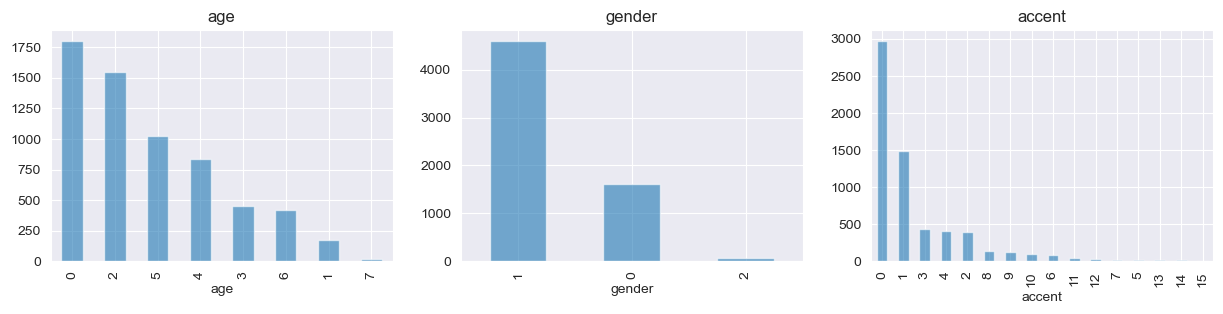

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, c in enumerate(["age", "gender", "accent"]):
    df_features[c].value_counts().plot.bar(title=c, ax=axes[i], alpha=0.6)
plt.show();

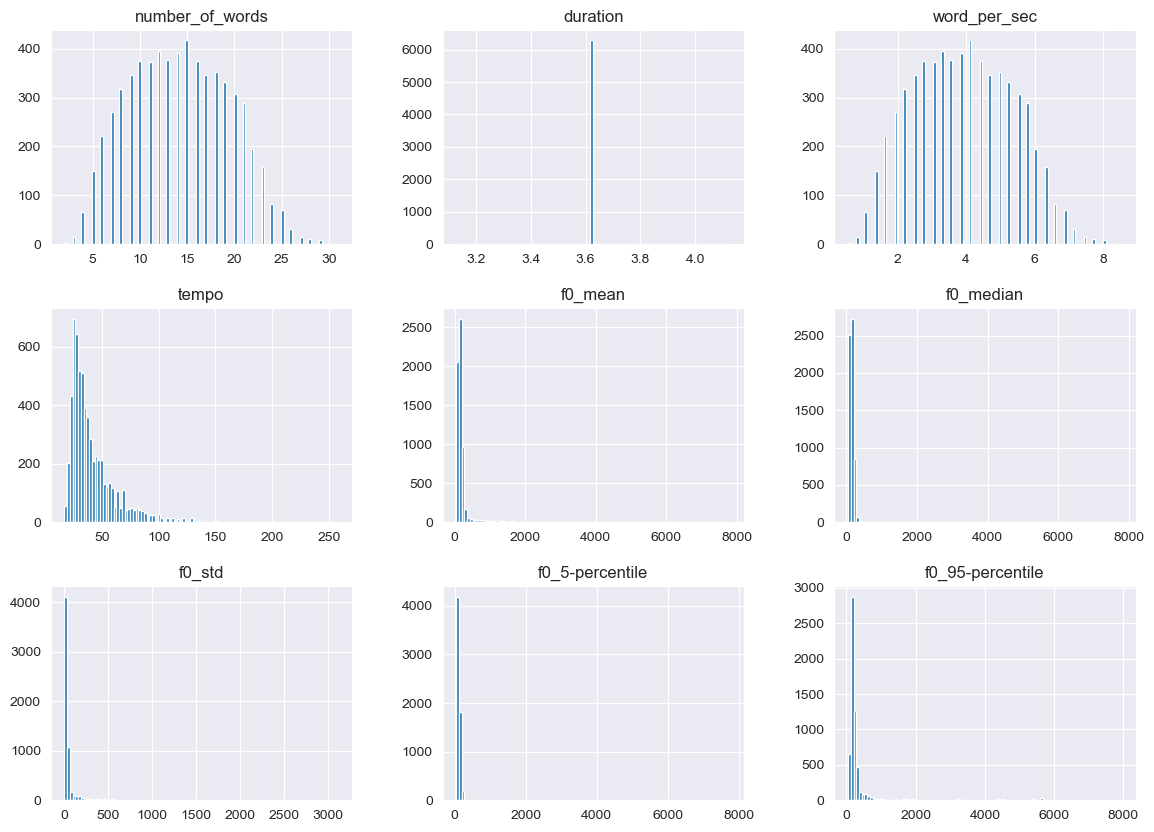

In [20]:
# df_features.drop(columns=["age", "gender", "filename", "accent"]).hist(bins=100, figsize=(14, 10))
df_features.iloc[:, :13].drop(columns=["age", "gender", "filename", "accent"], errors='ignore').hist(bins=100, figsize=(14, 10))
plt.show();

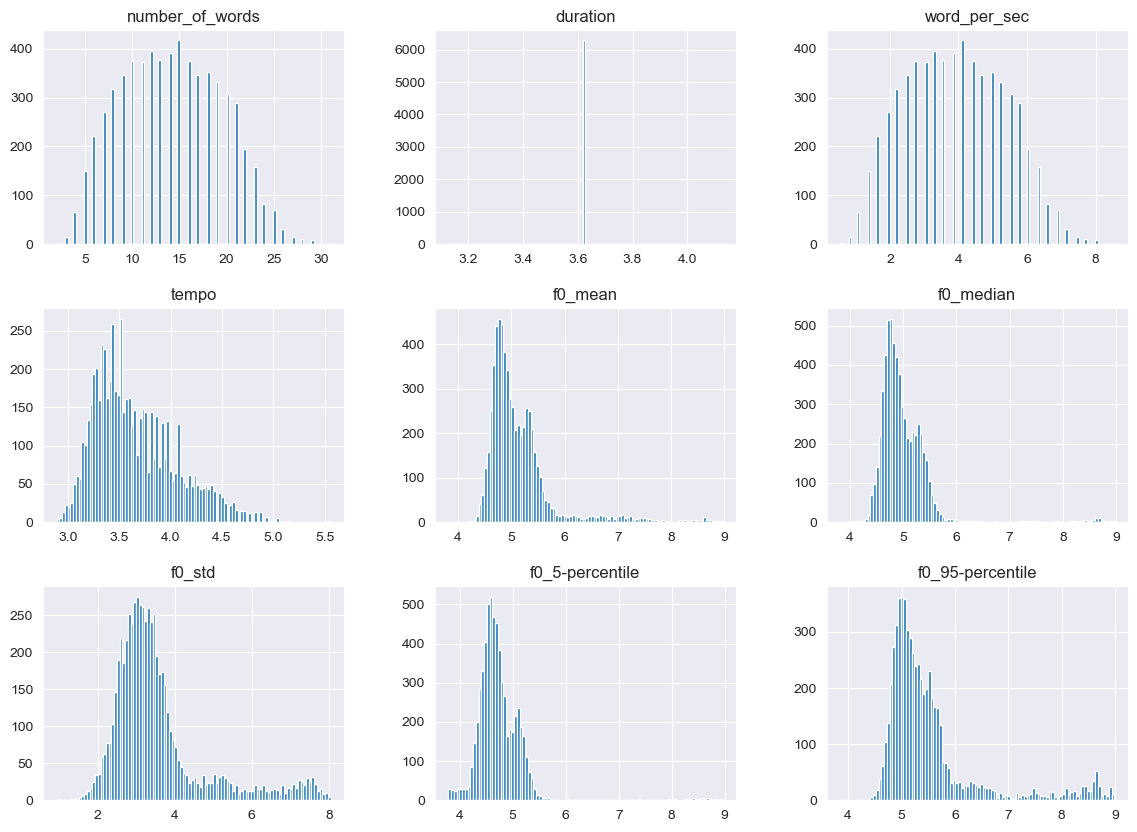

In [21]:
# Applies log1p on features that are not age, gender, filename or words_per_second
df_features_transform = df_features.apply(
    lambda x: np.log1p(x)
    if x.name in ["tempo", "f0_mean", "f0_median", "f0_std", "f0_5-percentile", "f0_95-percentile"]
    else x)

# Let's look at the distribution once more
df_features_transform.iloc[:, :13].drop(columns=["age", "gender", "filename", "accent"], errors='ignore').hist(bins=100, figsize=(14, 10))
plt.show();

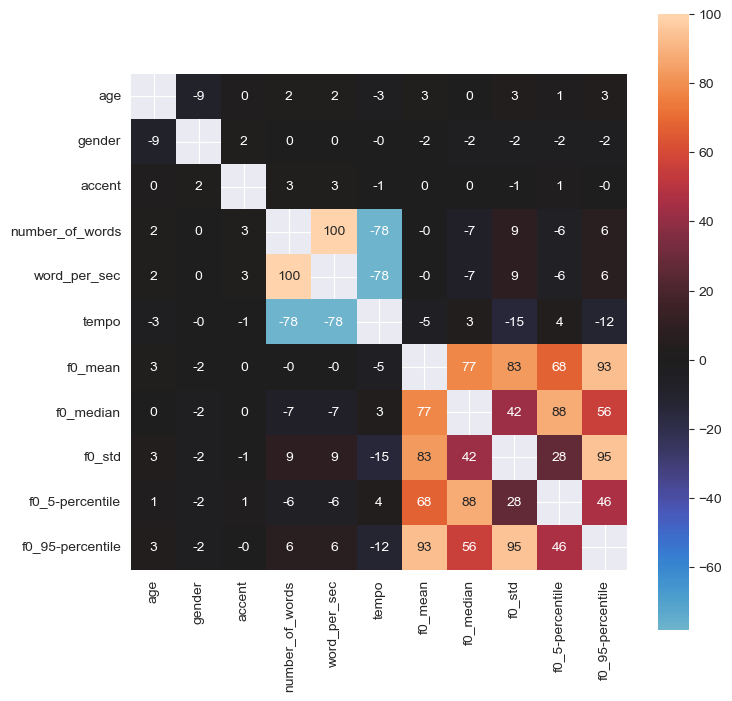

In [22]:
plt.figure(figsize=(8, 8))
df_corr = df_features_transform.iloc[:, 1:13].drop(columns=["duration"], errors='ignore').corr() * 100
sns.heatmap(df_corr, square=True, annot=True, fmt=".0f", 
            mask=np.eye(len(df_corr)), center=0)
plt.show()

In [49]:
def draw_pca_capture(target):
    x = df_features_transform.drop(columns=["filename", target]).reset_index(drop=True)
    y = df_features_transform[target].values
    pca = PCA()
    pca.fit(x)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    

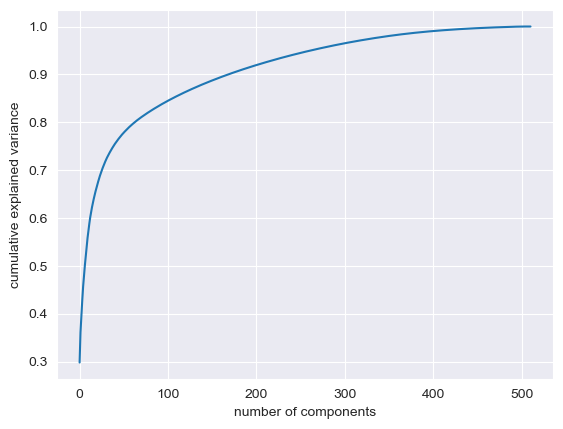

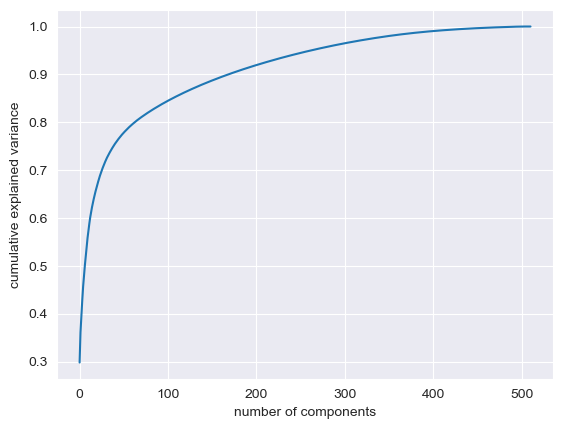

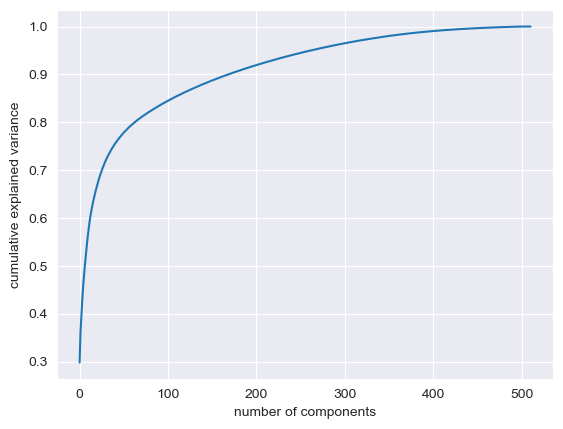

In [52]:
targets = ["age","gender","accent"]
for target in targets:
    draw_pca_capture(target)
    plt.show()
    

In [106]:
def draw_2d_PCA(target):
    x = df_features_transform.drop(columns=["filename", target]).reset_index(drop=True)
    y = df_features_transform[target].values
    pca = PCA(n_components=2)
    X_PCA = pca.fit_transform(x)
    df_pca = pd.DataFrame(X_PCA, columns=["PCA1", "PCA2"])
    df_pca[target] = y
    print(df_pca.head(1))

    # Plot the PCA-transformed data
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df_pca["PCA1"], df_pca["PCA2"], c=df_pca[target], cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label=target)
    plt.title("PCA Visualization (2 Components)", fontsize=14)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.grid()
    plt.show()

In [73]:

def predict(x,y,n_components = 0):
    warnings.filterwarnings("ignore")
    if n_components>0:
        pca = PCA(n_components=n_components)
        x = pca.fit_transform(x)
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, train_size=0.8, shuffle=True, stratify=y, random_state=0)
        
    model = LogisticRegression(max_iter=1000, random_state=0, solver='lbfgs')
    model.fit(x_tr, y_tr)
    # Make predictions on the test set
    y_pred = model.predict(x_te)
    # Evaluate the model
    print(f"Classification Report with target: {target} and n_components ={n_components}:")
    print(classification_report(y_te, y_pred))
    print("Accuracy Score:", accuracy_score(y_te, y_pred))
    
    cm = confusion_matrix(y_te, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix for {target} with n_components={n_components}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    

Classification Report with target: age and n_components =0:
              precision    recall  f1-score   support

           0       0.30      0.42      0.35       360
           1       0.00      0.00      0.00        34
           2       0.24      0.25      0.25       310
           3       0.09      0.05      0.07        91
           4       0.20      0.11      0.15       168
           5       0.17      0.10      0.13       205
           6       0.08      0.06      0.07        85
           7       0.00      0.00      0.00         4

    accuracy                           0.22      1257
   macro avg       0.13      0.13      0.13      1257
weighted avg       0.21      0.22      0.21      1257

Accuracy Score: 0.22354813046937153


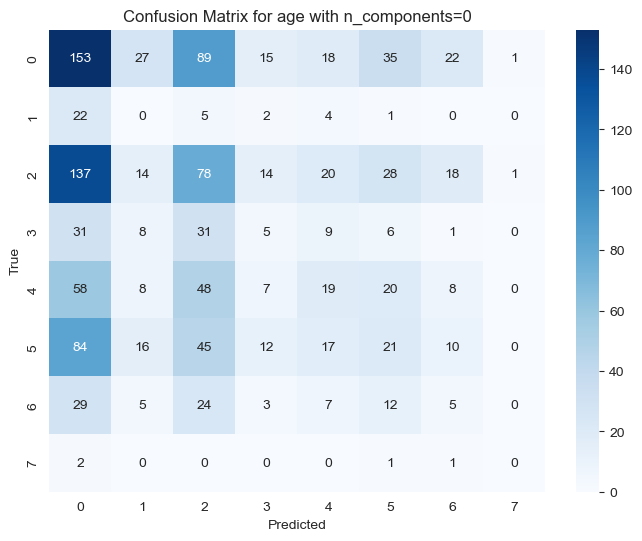

Classification Report with target: age and n_components =2:
              precision    recall  f1-score   support

           0       0.29      1.00      0.44       360
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00       310
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00       168
           5       0.00      0.00      0.00       205
           6       0.00      0.00      0.00        85
           7       0.00      0.00      0.00         4

    accuracy                           0.29      1257
   macro avg       0.04      0.12      0.06      1257
weighted avg       0.08      0.29      0.13      1257

Accuracy Score: 0.2856006364359586


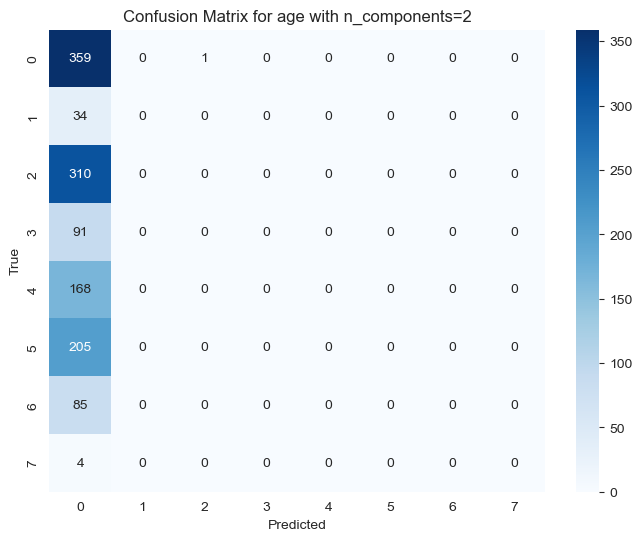

Classification Report with target: age and n_components =200:
              precision    recall  f1-score   support

           0       0.29      0.68      0.40       360
           1       0.00      0.00      0.00        34
           2       0.25      0.15      0.19       310
           3       0.00      0.00      0.00        91
           4       0.12      0.03      0.05       168
           5       0.16      0.08      0.11       205
           6       0.09      0.04      0.05        85
           7       0.00      0.00      0.00         4

    accuracy                           0.25      1257
   macro avg       0.11      0.12      0.10      1257
weighted avg       0.19      0.25      0.19      1257

Accuracy Score: 0.25139220365950676


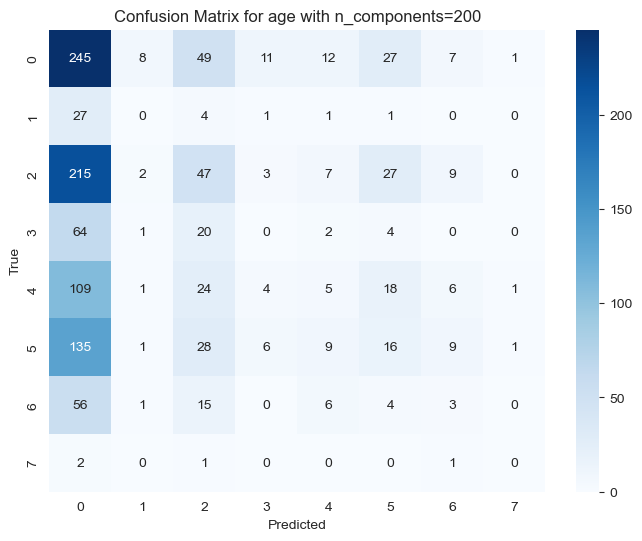

Classification Report with target: gender and n_components =0:
              precision    recall  f1-score   support

           0       0.22      0.07      0.11       324
           1       0.73      0.89      0.80       919
           2       0.00      0.00      0.00        14

    accuracy                           0.67      1257
   macro avg       0.32      0.32      0.30      1257
weighted avg       0.59      0.67      0.61      1257

Accuracy Score: 0.6674622116149562


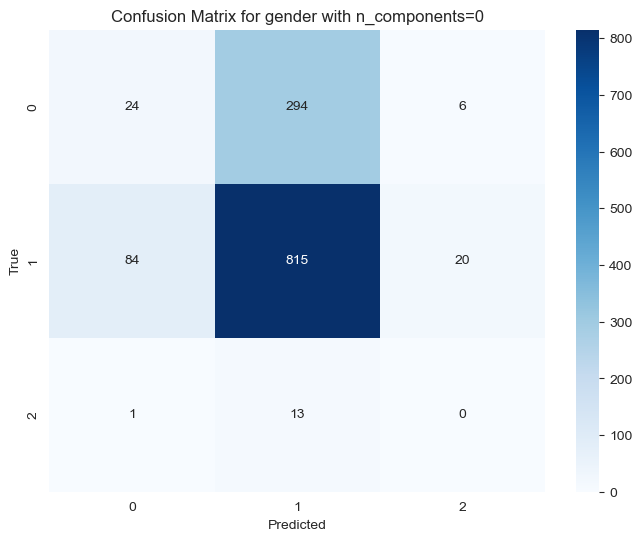

Classification Report with target: gender and n_components =2:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       324
           1       0.73      1.00      0.84       919
           2       0.00      0.00      0.00        14

    accuracy                           0.73      1257
   macro avg       0.24      0.33      0.28      1257
weighted avg       0.53      0.73      0.62      1257

Accuracy Score: 0.7311058074781225


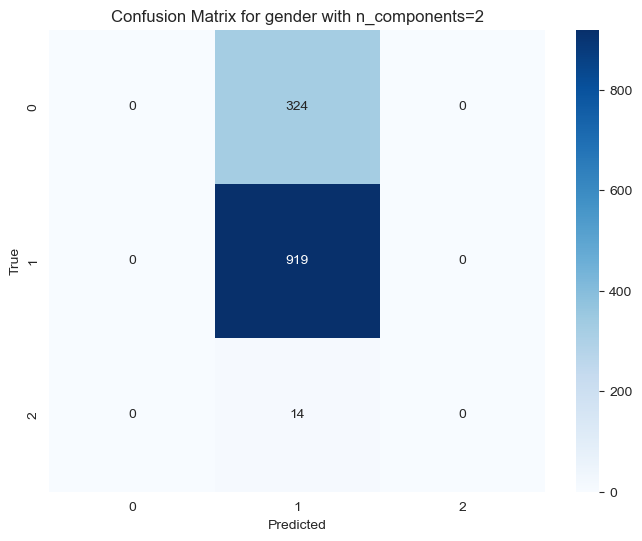

Classification Report with target: gender and n_components =200:
              precision    recall  f1-score   support

           0       0.15      0.01      0.02       324
           1       0.73      0.97      0.83       919
           2       0.00      0.00      0.00        14

    accuracy                           0.71      1257
   macro avg       0.29      0.33      0.29      1257
weighted avg       0.57      0.71      0.62      1257

Accuracy Score: 0.7136038186157518


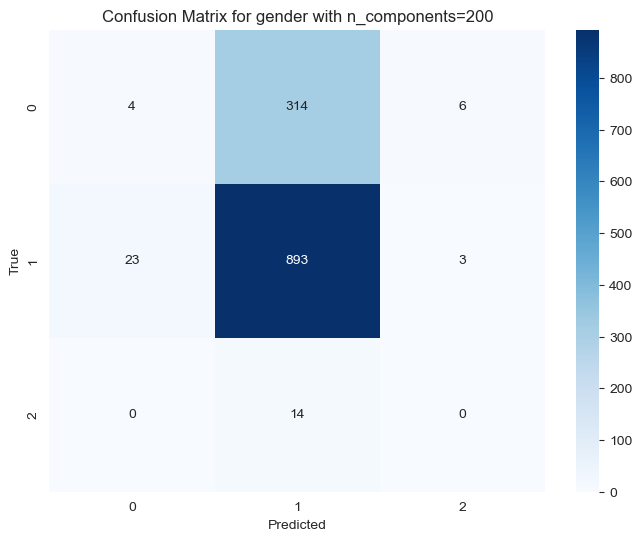

Classification Report with target: accent and n_components =0:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51       594
           1       0.21      0.10      0.14       298
           2       0.03      0.03      0.03        79
           3       0.11      0.07      0.08        88
           4       0.06      0.04      0.05        81
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00         4
           8       0.07      0.11      0.08        27
           9       0.02      0.04      0.03        25
          10       0.06      0.10      0.07        20
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy     

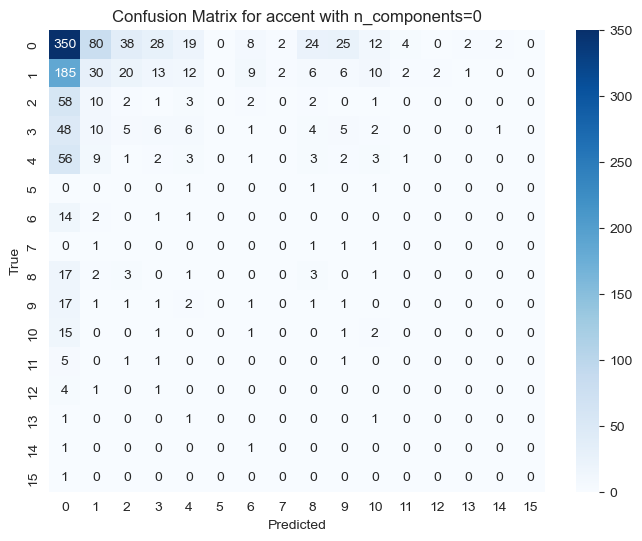

Classification Report with target: accent and n_components =2:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       594
           1       0.00      0.00      0.00       298
           2       0.00      0.00      0.00        79
           3       0.00      0.00      0.00        88
           4       0.00      0.00      0.00        81
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        20
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy     

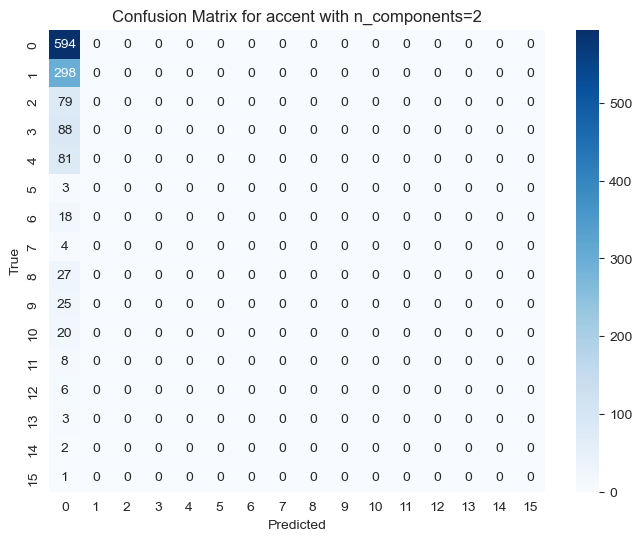

Classification Report with target: accent and n_components =200:
              precision    recall  f1-score   support

           0       0.47      0.83      0.60       594
           1       0.29      0.07      0.12       298
           2       0.00      0.00      0.00        79
           3       0.15      0.02      0.04        88
           4       0.00      0.00      0.00        81
           5       0.12      0.33      0.18         3
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        20
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1

    accuracy   

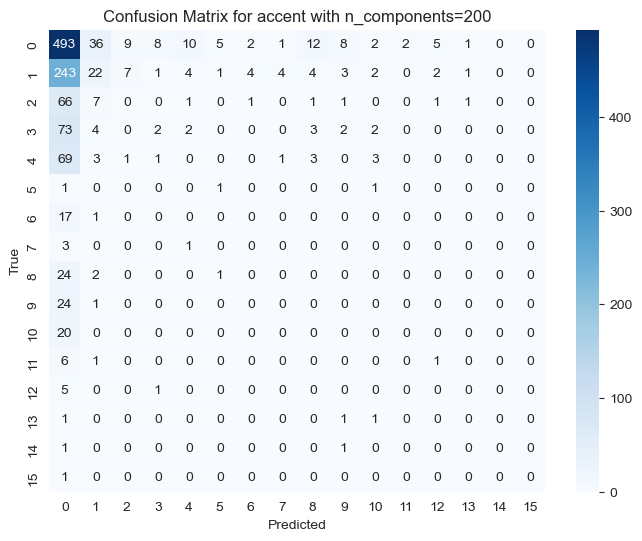

In [74]:
for target in targets:
    for i in [0,2,200]:
        warnings.filterwarnings("ignore")
        x = df_features_transform.drop(columns=["filename", target]).reset_index(drop=True)
        y = df_features_transform[target].values
        predict(x,y,n_components = i)

# Single Test: preprocessing

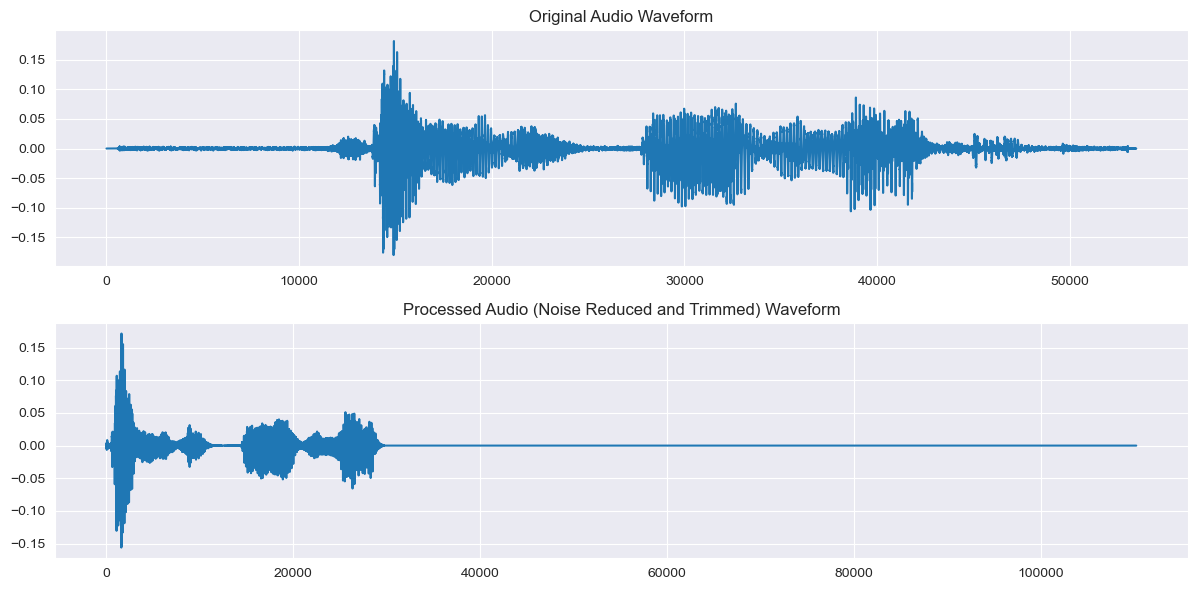

In [97]:
mp3_filename = "cv-valid-train/sample-006317.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, sr = librosa.load(mp3_file_path)
y_trim,sr = preprocessing(mp3_file_path,sr)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y)
plt.title('Original Audio Waveform')

plt.subplot(2, 1, 2)
plt.plot(y_trim)
plt.title('Processed Audio (Noise Reduced and Trimmed) Waveform')

plt.tight_layout()
plt.show()

# Single Test: Onset

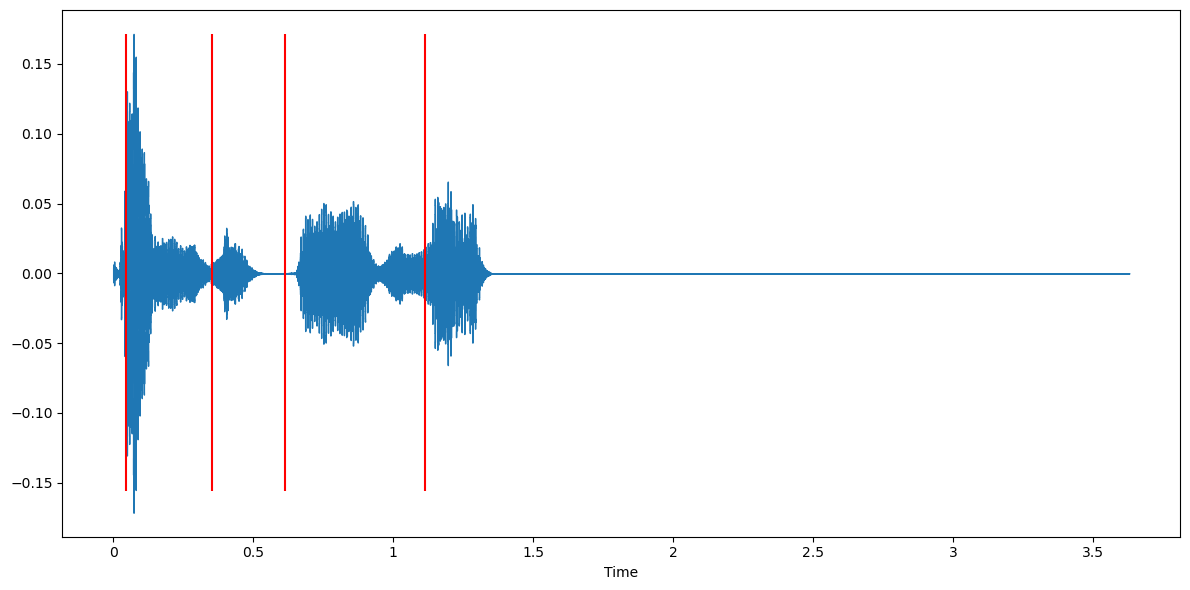

4 onsets were detected in this audio signal.
3.6281179138321997


In [365]:
onsets = librosa.onset.onset_detect(y=y_trim, sr=sr, units="time", hop_length=128, backtrack=True)
plt.figure(figsize=(12, 6))
for o in onsets:
    plt.vlines(o, min(y_trim), max(y_trim), colors="r")
librosa.display.waveshow(y_trim,sr=sr)
plt.tight_layout()
plt.show()
# Return number of onsets
number_of_words = len(onsets)
print(f"{number_of_words} onsets were detected in this audio signal.")

duration = librosa.get_duration(y=y_trim,sr=sr)
print(duration)

# Single Test: Fundamental frequency

In [366]:
f0_values = pitch(y=y_trim, sr=sr)

# Single Test: FFT

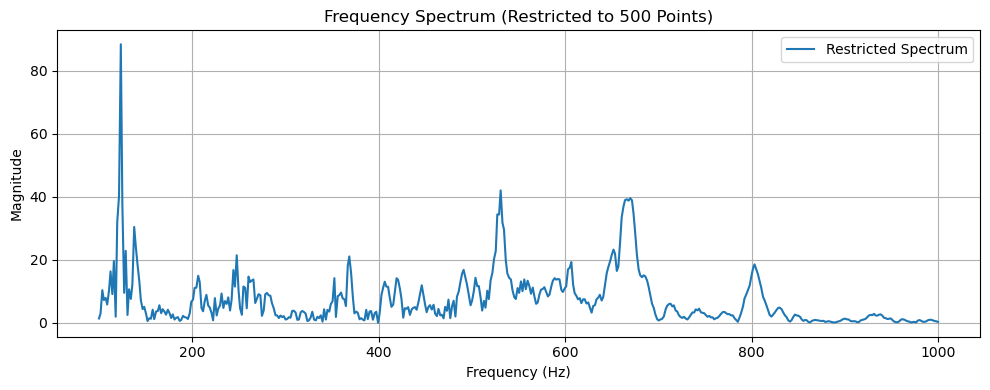

In [367]:
r = fft(y_trim,sr)
sampled_frequencies = r.keys()
sampled_magnitudes = r.values()
# Plot the restricted spectrum
plt.figure(figsize=(10, 4))
plt.plot(sampled_frequencies, sampled_magnitudes, label="Restricted Spectrum")
plt.title("Frequency Spectrum (Restricted to 500 Points)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [102]:
mp3_filename = "cv-valid-train/sample-000007.mp3" 
mp3_file_path = os.path.join(mp3_folder, mp3_filename)
y, sr = librosa.load(mp3_file_path)

reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)
y_trim, _ = librosa.effects.trim(reduced_noise, top_db=20)
f0 = pitch(y_trim,sr)
print(f0)
print(y_trim.shape)
if len(y_trim) < 5 * 16000:
    print("pad")
    y_trim = np.pad(y_trim, (0, 5 * 16000 - len(y_trim)), mode='constant')
else:
    y_trim = y_trim[:5 * 16000]
print(y_trim.shape)
f0 = pitch(y_trim,sr)
print(f0)


{'f0_mean': 383.5960807872473, 'f0_median': 119.1741970498162, 'f0_std': 671.7510497536831, 'f0_5-percentile': 98.37809914694911, 'f0_95-percentile': 2096.2719870138417}
(58368,)
pad
(80000,)
{'f0_mean': 114.40776555248654, 'f0_median': 112.81127415981778, 'f0_std': 12.24853281794471, 'f0_5-percentile': 94.0438325026887, 'f0_95-percentile': 136.30386034140676}


In [368]:
# # Iterate over each row in the DataFrame
# for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing MP3 files", unit="file"):
#     mp3_filename = row['filename']  # Adjust if column name differs
#     mp3_file_path = os.path.join(mp3_folder, mp3_filename)
#     
#     # Check if the MP3 file exists
#     if os.path.exists(mp3_file_path):
#         # preprocessing
#         y, sample_rate = preprocessing(mp3_file_path,sr)
#         
#         # Onset
#         number_of_words, duration, word_per_sec  = onset(y=y, sr=sample_rate)
#         df.at[index, 'number_of_words'] = number_of_words
#         df.at[index, 'duration'] = duration
#         df.at[index, 'word_per_sec'] = word_per_sec
#         # Tempo
#         tempo = librosa.feature.rhythm.tempo(y=y, sr=sample_rate, start_bpm=10)[0]
#         df.at[index, 'tempo'] = tempo
#         # Pitch
#         f0_values = pitch(y=y, sr=sample_rate)
#         for i, v in f0_values.items():
#             df.at[index, i] = v
#         # FFT
#         magnitudes = fft(y=y, sr=sample_rate)
#         for i, v in magnitudes.items():
#             df.at[index, i] = v
#         
# 
# print("Finished extracting MP3 files.")